<a href="https://colab.research.google.com/github/foobari/foobari.github.io/blob/master/stock_ai_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [410]:
# LTSM test on stock

In [411]:
# Imports
import math
import pandas_datareader as web
import numpy as np
import pandas.testing as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [412]:
#Get the stock quote 
df = web.DataReader('^GDAXI', data_source='yahoo', start='2012-01-01', end='2020-06-30')
#df = web.DataReader('SI=F', data_source='yahoo', start='2012-01-01', end='2020-06-30') 
#Show the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-02,6075.520020,5900.180176,5900.180176,6075.520020,90828400.0,6075.520020
2012-01-03,6179.029785,6108.620117,6124.109863,6166.569824,116709200.0,6166.569824
2012-01-04,6163.479980,6088.060059,6141.259766,6111.549805,100870800.0,6111.549805
2012-01-05,6130.100098,6040.939941,6121.339844,6095.990234,141738400.0,6095.990234
2012-01-06,6152.560059,6012.640137,6114.640137,6057.919922,109973700.0,6057.919922
...,...,...,...,...,...,...
2020-06-24,12489.240234,12093.940430,12459.809570,12093.940430,102775200.0,12093.940430
2020-06-25,12236.459961,11957.309570,12102.250000,12177.870117,128245800.0,12177.870117
2020-06-26,12347.450195,12060.889648,12308.480469,12089.389648,111965200.0,12089.389648


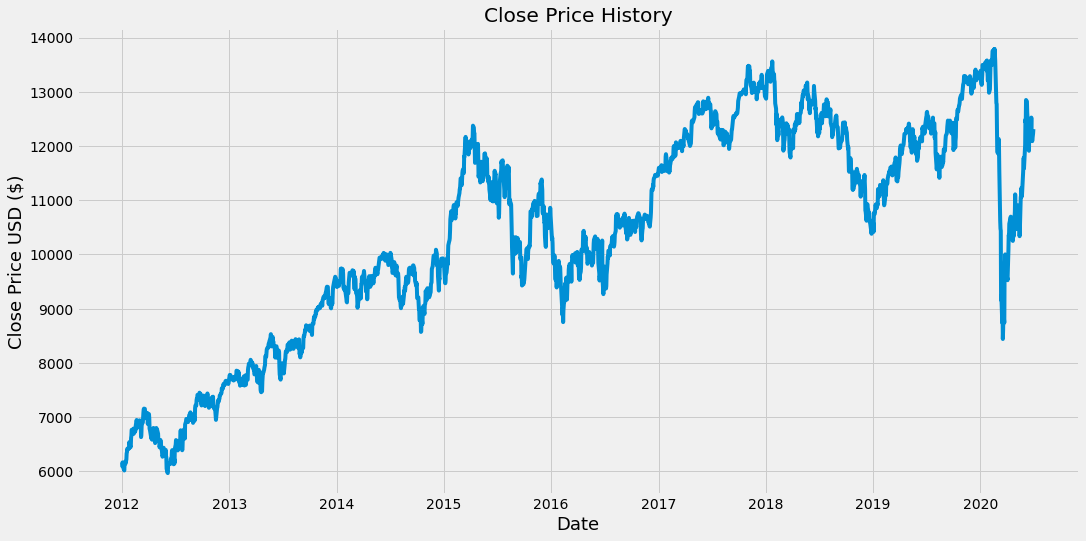

In [413]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [414]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [415]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
#plt.plot(scaled_data)
#plt.show()
scaled_data.shape

(2144, 1)

In [416]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#print("Train data len: ", train_data.shape)
#Split the data into x_train and y_train data sets
input_train=[]
output_train = []
for i in range(60,len(train_data)):
    input_train.append(train_data[i-60:i,0])
    output_train.append(train_data[i,0])

In [417]:
#Convert x_train and y_train to numpy arrays
input_train, ouput_train = np.array(input_train), np.array(output_train)

#Reshape the data into the shape accepted by the LSTM
input_train = np.reshape(input_train, (input_train.shape[0],input_train.shape[1],1))

#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(input_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [418]:
#Train the model
model.fit(input_train, output_train, batch_size=1, epochs=1)

#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

#Convert x_test to a numpy array 
x_test = np.array(x_test)    

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

#Calculate/Get the value of RMSE
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))
print("Mean error squared: ", rmse)

Epoch 1/1
1656/1656 [==============================] - 62s 37ms/step - loss: 0.0020
Mean error squared:  367.2742624814434


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


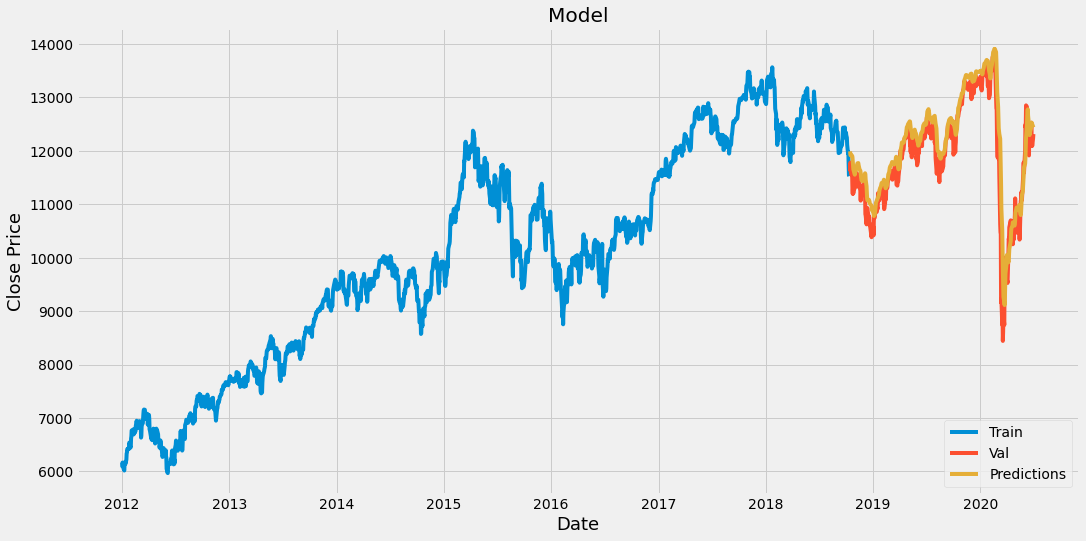

In [419]:
#Plot/Create the data for the graph
train = data[:training_data_len]
real = data[training_data_len:]
real['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(real[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


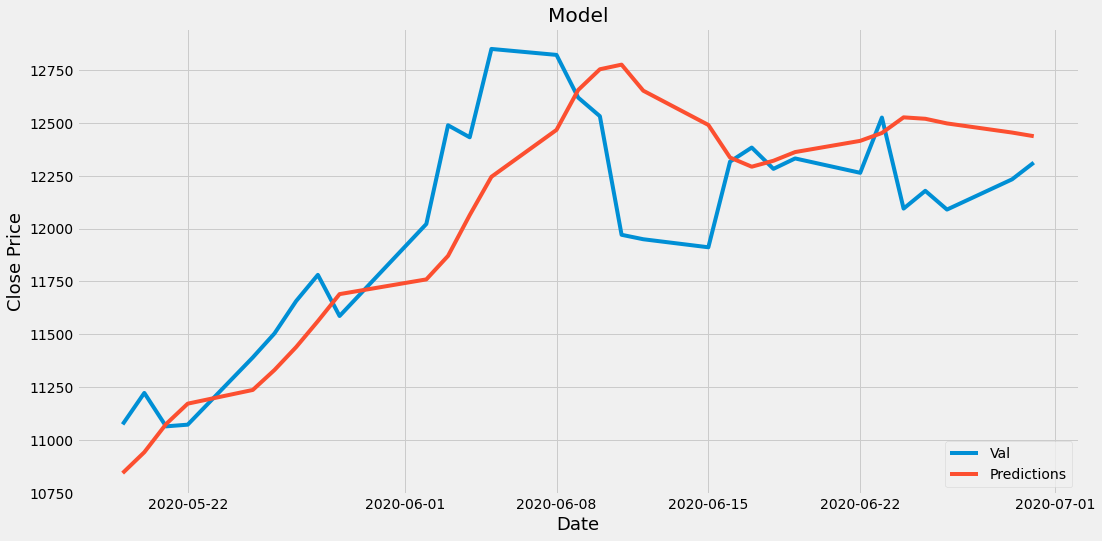

Expected close:  [12435.79]


In [420]:
#Plot/Create the data for the graph
#train = data[:training_data_len]
#valid = data[training_data_len:]
#valid['Predictions'] = predictions

show_len = 30
pred_start_idx = len(predictions) - show_len

valid = data[len(data)-show_len:]

valid.insert(1, 'Predictions', predictions[pred_start_idx:, 0], True)

#valid['Close'][-1] = None

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

print("Expected close: ", predictions[-1])
